### Initialization

In [1]:
import pandas as pd
import numpy as np
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.model.model_base import ModelBase
from h2o.backend import H2OLocalServer
import math
import shap
import subprocess
import os
import re
from IPython.display import Image
from IPython.display import display
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import pickle
import graphviz
from graphviz import Source

## View all columns and rows
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
shap.initjs() # Load javascript visualization capabilities

In [3]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Zulu11.43+55-CA (build 11.0.9.1+1-LTS, mixed mode)
  Starting server from C:\Users\ID75147\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ID75147\AppData\Local\Temp\1\tmpuqve4lrp
  JVM stdout: C:\Users\ID75147\AppData\Local\Temp\1\tmpuqve4lrp\h2o_ID75147_started_from_python.out
  JVM stderr: C:\Users\ID75147\AppData\Local\Temp\1\tmpuqve4lrp\h2o_ID75147_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.4
H2O_cluster_version_age:,1 month
H2O_cluster_name:,H2O_from_python_ID75147_jazrpu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.910 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"accepting new members, healthy"


In [4]:
# Read in modeling data
masterdata = h2o.import_file('Testing_with_errors.csv',
                             destination_frame = 'masterdata.hex',
                             na_strings = ['nan','',' '])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
masterdata.columns

['trans_tracking_nbr',
 'Year',
 'min_age_oldest_driver',
 'min_age_youngest_driver',
 'min_cbr',
 'min_cbr_insufficientcredit_ind',
 'min_cbr_nohit_ind',
 'min_cbrscore',
 'min_chargeable13',
 'min_chargeable45',
 'min_drivers',
 'min_newest_vehicle',
 'min_oldest_vehicle',
 'min_pd_limit',
 'min_premium',
 'min_qtever',
 'min_vehicles',
 'max_age_oldest_driver',
 'max_age_youngest_driver',
 'max_cbr',
 'max_cbr_insufficientcredit_ind',
 'max_cbr_nohit_ind',
 'max_cbrscore',
 'max_chargeable13',
 'max_chargeable45',
 'max_drivers',
 'max_newest_vehicle',
 'max_oldest_vehicle',
 'max_pd_limit',
 'max_premium',
 'max_qtever',
 'max_vehicles',
 'mean_age_oldest_driver',
 'mean_age_youngest_driver',
 'mean_cbr',
 'mean_cbr_insufficientcredit_ind',
 'mean_cbr_nohit_ind',
 'mean_cbrscore',
 'mean_chargeable13',
 'mean_chargeable45',
 'mean_drivers',
 'mean_newest_vehicle',
 'mean_oldest_vehicle',
 'mean_pd_limit',
 'mean_premium',
 'mean_qtever',
 'mean_vehicles',
 'mean_age_oldest_driver_m

In [6]:
masterdata.types

{'trans_tracking_nbr': 'int',
 'Year': 'int',
 'min_age_oldest_driver': 'real',
 'min_age_youngest_driver': 'real',
 'min_cbr': 'real',
 'min_cbr_insufficientcredit_ind': 'real',
 'min_cbr_nohit_ind': 'real',
 'min_cbrscore': 'real',
 'min_chargeable13': 'real',
 'min_chargeable45': 'real',
 'min_drivers': 'real',
 'min_newest_vehicle': 'real',
 'min_oldest_vehicle': 'real',
 'min_pd_limit': 'real',
 'min_premium': 'real',
 'min_qtever': 'real',
 'min_vehicles': 'real',
 'max_age_oldest_driver': 'real',
 'max_age_youngest_driver': 'real',
 'max_cbr': 'real',
 'max_cbr_insufficientcredit_ind': 'real',
 'max_cbr_nohit_ind': 'real',
 'max_cbrscore': 'real',
 'max_chargeable13': 'real',
 'max_chargeable45': 'real',
 'max_drivers': 'real',
 'max_newest_vehicle': 'real',
 'max_oldest_vehicle': 'real',
 'max_pd_limit': 'real',
 'max_premium': 'real',
 'max_qtever': 'real',
 'max_vehicles': 'real',
 'mean_age_oldest_driver': 'real',
 'mean_age_youngest_driver': 'real',
 'mean_cbr': 'real',
 'm

In [7]:
TargetVar = 'percentile_rec_errors'
FeatureVarList = list(set(masterdata.columns)-set([TargetVar, 'trans_tracking_nbr', 'Year']))
#FeatureVarList = ['office_name_adams', 'vehicletype_van', 'uninsuredmotoristspropertydamagedeductible_100']
# masterdata[TargetVar] = masterdata[TargetVar].asfactor()

# Depth of 4

In [8]:
gbm_lucky = H2OGradientBoostingEstimator(
    model_id = 'gbm_simple',
    max_depth = 4,
    ntrees = 1,
    learn_rate = 0.01,                                                         
    sample_rate = 1.0,                                                       
    col_sample_rate = 1.0,                                                   
    seed = 1234,                                                             
    score_tree_interval = 10)

gbm_lucky.train(x=FeatureVarList, y=TargetVar, training_frame=masterdata)
gbm_lucky

Dropping bad and constant columns: [occupation_discount_eft, incident_group_nan, large_farm_truck_nan, mpd_autoagree, male_nan, semi_farm_truck_nan, female_nan, tenuresub_nan, bill_mode_automonthl, mean_age_oldest_driver_missing_ind, pleasure_only_nan, farm_use_nan, mean_oldest_vehicle_missing_ind, vehicleownership_nan, tenuresub_new, gradepointavg_below30top, married_nan, office_name_tricity, activedutyalertind_y, office_name_summitagency, mean_newest_vehicle_missing_ind]


gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_simple


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,1.0,1.0,257.0,4.0,4.0,4.0,16.0,16.0,16.0




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.08287222902700639
RMSE: 0.2878753706502284
MAE: 0.24940466827197252
RMSLE: 0.19811406342653823
Mean Residual Deviance: 0.08287222902700639

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2021-08-09 13:58:25,0.026 sec,0.0,0.288674,0.249999,0.083333
1,,2021-08-09 13:58:28,3.549 sec,1.0,0.287875,0.249405,0.082872



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,mean_bipdsymbol_missing_ind,2803.348145,1.000000,0.340616
1,activedutyalertind_n,2360.005615,0.841852,0.286748
2,gradepointavg_nan,1350.839233,0.481866,0.164131
3,requote_n,820.345398,0.292631,0.099675
4,uninsuredmotoristspropertydamageind_nan,541.948792,0.193322,0.065849
5,min_qtever,131.067642,0.046754,0.015925
6,snowplowliability_n,126.007729,0.044949,0.015310
7,assignablevehind_n,55.057552,0.019640,0.006690
8,makeliteral_other,26.921793,0.009603,0.003271
9,vehicletype_cruistour,14.686730,0.005239,0.001784



See the whole table with table.as_data_frame()


contributions progress: |█████████████████████████████████████████████████| 100%


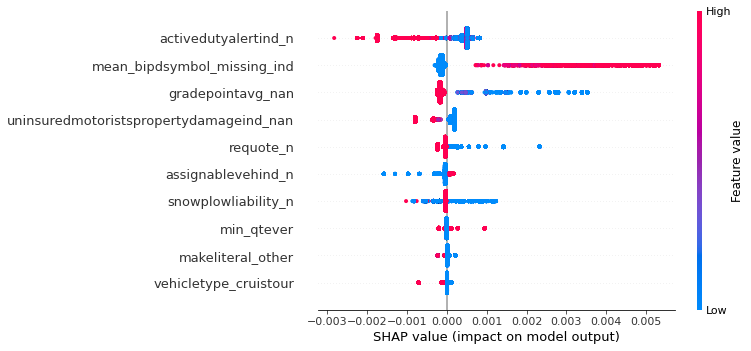

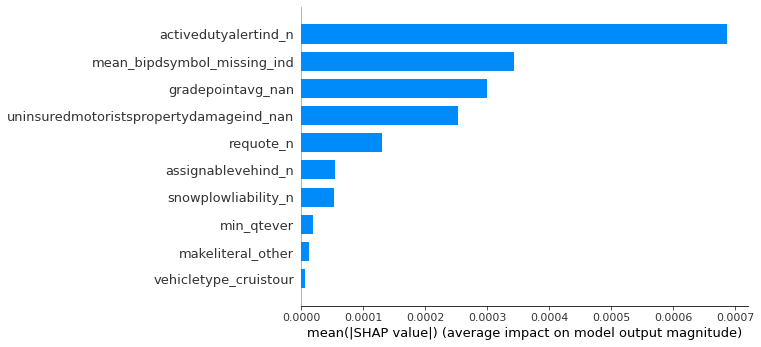

In [9]:
contributions = gbm_lucky.predict_contributions(masterdata).as_data_frame()

del contributions['BiasTerm']

for CurFeature in list(contributions.columns): # Iterate through features
    if len(contributions[CurFeature].unique()) <= 1: # If only one value occurs across all rows
        del contributions[CurFeature] # Delete feature

ExplainedColumns=list(contributions.columns)

contributions_matrix = contributions.values

shap.summary_plot(contributions_matrix, masterdata[ExplainedColumns].as_data_frame())
shap.summary_plot(contributions_matrix, masterdata[ExplainedColumns].as_data_frame(), plot_type="bar")

In [10]:
##################################################################################################

In [11]:
gbm_lucky.download_mojo("./{}.zip".format('gbm_simple'))

'C:\\Users\\ID75147\\Desktop\\Quote_outliers_2.0\\quote-outlier-project-2.0\\gbm_simple.zip'

In [12]:
!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org graphviz

In [13]:
def convertTreeToGZ(ModelID='gbm_simple'):
    """
    Function to convert tree to a GraphWiz visualization
    Parameters: 
        ModelID(str): Name (in model repository) of model to be extracted 
    """
    # Determine location of H2O JAR Path
    hs = H2OLocalServer()
    h2o_jar_path = "./h2o.jar"
    # Define key file locations
    MojoFile = "./{}.zip".format(ModelID) # Define MOJO file location
    GVFile = "./{}.gv".format(ModelID) # Define GraphWiz file location
    # Execute command line call to construct graphwiz version of tree
    gv_args = str('-cp ' + h2o_jar_path +
                  ' hex.genmodel.tools.PrintMojo --tree 0 -i '
                  + MojoFile + ' -o').split()
    gv_args.insert(0, 'java')
    gv_args.append(GVFile)
    _ = subprocess.call(gv_args)
    print("Constructed GraphWiz file {}".format(GVFile))


In [14]:
convertTreeToGZ()

Constructed GraphWiz file ./gbm_simple.gv
